<a href="https://colab.research.google.com/github/yaelglz/IA/blob/main/Recurrentes/humedadSuelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Equipo:

Gonzalez Muñoz Yael Abraham

Martínez Sánchez Jared

## Introducción al Análisis de Series Temporales de Humedad

Este notebook tiene como objetivo demostrar un modelo de Recurrent Neural Network (RNN) para predecir los niveles de humedad del suelo en una parcela de trigo. La base de datos contiene mediciones de diferentes sensores (Temperatura, Humedad, Conductividad Eléctrica del Suelo - Soil EC, Nitrógeno, Fósforo, Potasio) a varias profundidades (5 cm, 20 cm, 40 cm, 60 cm, 80 cm, 100 cm) y nutrientes (6.3 cm). Los datos se toman cada 8 horas, lo que es crucial para la naturaleza de serie temporal de este análisis. En este caso específico, nos centraremos en la **humedad a 5 cm de profundidad**.

## Bloque 1: Importación de Librerías Principales

En este bloque, importamos todas las librerías necesarias para el análisis. `pandas` y `numpy` son fundamentales para la manipulación y operación de datos. `matplotlib.pyplot` se utiliza para la visualización. `MinMaxScaler` de `sklearn.preprocessing` es para escalar los datos. Finalmente, `tensorflow.keras` proporciona las herramientas para construir y entrenar nuestro modelo RNN, incluyendo capas (`SimpleRNN`, `Dense`) y optimizadores (`Adam`).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam


## Bloque 2: Carga y Exploración Inicial de Datos

Aquí cargamos el conjunto de datos de humedad desde una URL de GitHub en un DataFrame de pandas. Este DataFrame `df` contiene todas las mediciones de los diferentes sensores en la parcela de trigo. El objetivo es obtener una primera vista de la estructura de los datos, incluyendo las columnas disponibles como 'Plot ID', 'Plot Name', 'Plot Location', 'Sensor ID', 'Sensor Type', 'Depth (cm)', 'Timestamp' y 'Value', que serán clave para el siguiente filtrado.

In [3]:
import pandas as pd

# Leer el archivo CSV
df = pd.read_csv('https://gist.githubusercontent.com/yaelglz/ec544170c6a61be7d98c615c0cfd6e79/raw/6465171991b470c6648863c138fd8989fbf93d0a/plot-23.csv', sep=',', quotechar='"')
df.head()

,Plot ID,Plot Name,Plot Location,Sensor ID,Sensor Type,Depth (cm),NPK Set,Timestamp (America/Mexico_City),Value,Unit
0,4,Plot number 23,Treatment number 15,55,Temperature,5.0,NaN,"8/7/2025, 8:28:42 PM",16.3,°C
1,4,Plot number 23,Treatment number 15,55,Temperature,5.0,NaN,"8/8/2025, 10:01:24 AM",19.5,°C
2,4,Plot number 23,Treatment number 15,55,Temperature,5.0,NaN,"8/8/2025, 6:01:23 PM",18.2,°C
3,4,Plot number 23,Treatment number 15,55,Temperature,5.0,NaN,"8/9/2025, 2:01:10 AM",10.8,°C
4,4,Plot number 23,Treatment number 15,55,Temperature,5.0,NaN,"8/9/2025, 10:01:31 AM",18.4,°C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Plot ID                          5334 non-null   int64  
 1   Plot Name                        5334 non-null   object 
 2   Plot Location                    5334 non-null   object 
 3   Sensor ID                        5334 non-null   int64  
 4   Sensor Type                      5334 non-null   object 
 5   Depth (cm)                       5037 non-null   float64
 6   NPK Set                          297 non-null    float64
 7   Timestamp (America/Mexico_City)  5334 non-null   object 
 8   Value                            5334 non-null   float64
 9   Unit                             5334 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 416.8+ KB


## Bloque 3: Filtrado por Sensor de Humedad a 5 cm

Dado que nuestro objetivo es predecir la humedad del suelo, en este paso filtramos el DataFrame `df` para quedarnos únicamente con las mediciones del sensor de tipo 'Humidity' a una profundidad de '5 cm'. Este es el subconjunto específico de datos de interés para nuestro modelo de serie temporal. `reset_index(drop=True, inplace=True)` se utiliza para restablecer los índices del DataFrame filtrado.

In [ ]:
df_5cm = df[(df["Sensor Type"] == "Humidity") & (df["Depth (cm)"] == 5.0)].copy()
df_5cm.reset_index(drop=True, inplace=True)
df_5cm[["Timestamp (America/Mexico_City)", "Value"]].head()

,Timestamp (America/Mexico_City),Value
0,"8/7/2025, 8:28:42 PM",25.5
1,"8/8/2025, 10:01:24 AM",25.9
2,"8/8/2025, 6:01:23 PM",25.5
3,"8/9/2025, 2:01:10 AM",25.1
4,"8/9/2025, 10:01:31 AM",25.2


## Bloque 4: Selección de Columnas Relevantes y Manejo de Datos Faltantes

Aquí, seleccionamos las columnas que son directamente relevantes para nuestro modelo: 'Timestamp (America/Mexico_City)' (aunque su lógica de `datetime` ha sido eliminada, se mantiene para contexto del origen de datos) y 'Value'. Luego, eliminamos cualquier fila que contenga valores nulos (`dropna()`) en estas columnas, asegurando que el conjunto de datos esté limpio y completo para el modelado.

In [ ]:
df_selected = df_5cm[["Timestamp (America/Mexico_City)", "Value"]].copy()
df_selected = df_selected.dropna()
print(df_selected.head())

  Timestamp (America/Mexico_City)  Value
0            8/7/2025, 8:28:42 PM   25.5
1           8/8/2025, 10:01:24 AM   25.9
2            8/8/2025, 6:01:23 PM   25.5
3            8/9/2025, 2:01:10 AM   25.1
4           8/9/2025, 10:01:31 AM   25.2


## Bloque 5: Verificación del Tamaño de los Datos Filtrados

Este bloque simplemente imprime el número de registros restantes después de los pasos de filtrado y limpieza. Esto nos permite confirmar que tenemos una cantidad adecuada de datos para entrenar nuestro modelo.

In [ ]:
print(f"Número de datos después del filtrado: {len(df_selected)}")

Número de datos después del filtrado: 281


## Bloque 6: Conversión de Valores a Array de NumPy

Para preparar los datos para la entrada de la red neuronal, extraemos la columna 'Value' del DataFrame `df_selected` y la convertimos a un array de NumPy. Las redes neuronales, especialmente las RNN, suelen trabajar de manera más eficiente con datos en formato de array de NumPy.

In [ ]:
values = df_selected[["Value"]].values


## Bloque 7: Escalado Min-Max de Datos

El escalado de datos es un paso crucial en el preprocesamiento para redes neuronales. Utilizamos `MinMaxScaler` para escalar los valores de humedad al rango de (0, 1). Esto ayuda a que el modelo converja más rápido y mejore su rendimiento, ya que evita que características con rangos más grandes dominen el proceso de entrenamiento.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)


## Bloque 8: Creación de Secuencias para la Serie Temporal

Las RNNs trabajan con secuencias de datos. La función `create_sequences` toma el conjunto de datos escalado y lo transforma en pares de entrada-salida (`X`, `y`) para el modelo. `window_size` define cuántos puntos de datos anteriores se usarán para predecir el siguiente punto. En este caso, una ventana de 40 significa que usamos 40 valores de humedad previos para predecir el 41º valor.

In [ ]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i + window_size, 0])
    return np.array(sequences), np.array(labels)

window_size = 40
X, y = create_sequences(scaled_data, window_size)


## Bloque 9: División en Conjuntos de Entrenamiento y Prueba

Para evaluar el rendimiento del modelo de manera imparcial, dividimos los datos secuenciales (`X`, `y`) en conjuntos de entrenamiento (`X_train`, `y_train`) y prueba (`X_test`, `y_test`). El 80% de los datos se destina al entrenamiento y el 20% restante a la prueba. Esto asegura que el modelo sea evaluado con datos que no ha visto durante el entrenamiento.

In [ ]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


## Bloque 10: Definición del Modelo RNN

Aquí construimos nuestra Recurrent Neural Network (RNN) utilizando Keras. El modelo consta de dos capas `SimpleRNN` para capturar dependencias temporales en los datos, seguidas de capas `Dense` para procesar las salidas de las RNN y producir una única predicción. Se utiliza el optimizador Adam con una tasa de aprendizaje específica y la función de pérdida de error cuadrático medio (`mean_squared_error`), adecuada para problemas de regresión.

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=240, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model.add(SimpleRNN(units=120, return_sequences=False))
model.add(Dense(units=60))
model.add(Dense(units=1))

learning_rate = 0.0005
adam_optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Bloque 11: Entrenamiento del Modelo

En este paso, el modelo RNN se entrena utilizando los datos de entrenamiento (`X_train`, `y_train`). Se especifica un `batch_size` de 1, lo que significa que el modelo se actualiza después de cada muestra. Se entrena durante 15 `epochs` (pasadas completas sobre el conjunto de entrenamiento) y se utiliza un `validation_split` del 20% para monitorear el rendimiento del modelo en un subconjunto de datos no vistos durante cada época.

In [ ]:
history = model.fit(X_train, y_train, batch_size=1, epochs=15, validation_split=0.2)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.1923 - val_loss: 0.0035
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0122 - val_loss: 0.0072
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 5/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 6/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 7/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 8/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 9/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0156 - val_loss: 0.0035
Epoch 10/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0079 - val_loss: 0.0045
Epoch 11/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 12/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 

## Bloque 12: Visualización de la Función de Pérdida durante el Entrenamiento

Este gráfico muestra cómo la función de pérdida (error cuadrático medio) evoluciona a lo largo de las épocas tanto para el conjunto de entrenamiento como para el de validación. Es fundamental para diagnosticar si el modelo está aprendiendo correctamente (la pérdida disminuye) o si está sufriendo de sobreajuste (la pérdida de validación aumenta mientras la de entrenamiento sigue disminuyendo).

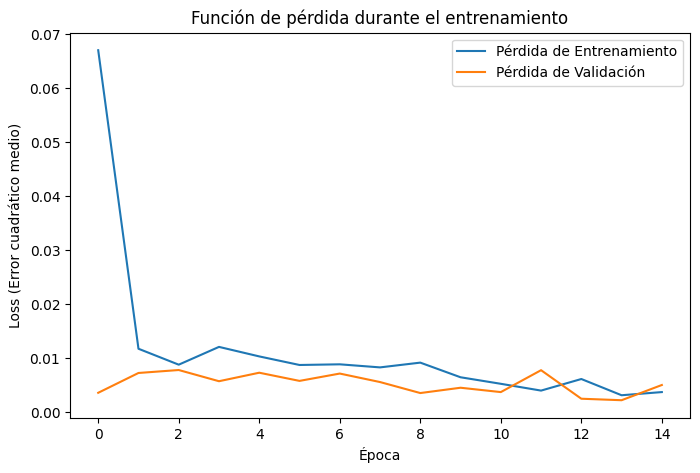

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Función de pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss (Error cuadrático medio)')
plt.legend()
plt.show()


## Bloque 13: Realización de Predicciones y Desescalado

Una vez entrenado el modelo, este bloque se encarga de generar predicciones sobre el conjunto de prueba (`X_test`). Es importante destacar que las predicciones se realizan sobre datos escalados, por lo que se utiliza `scaler.inverse_transform` para convertir tanto las predicciones como los valores reales de vuelta a su escala original. Esto permite interpretar los resultados en las unidades reales de humedad.

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 0))), axis=1))[:, 0]
y_test_real = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 0))), axis=1))[:, 0]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


## Bloque 14: Cálculo de Métricas de Evaluación

Para cuantificar la precisión de las predicciones del modelo, calculamos dos métricas comunes para problemas de regresión de series temporales: el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE). El MAE mide la magnitud promedio de los errores, mientras que el RMSE le da más peso a los errores grandes, siendo ambas métricas útiles para entender qué tan bien el modelo se ajusta a los datos reales.

In [ ]:
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 1.8554251222738203
RMSE: 1.9944280816729811


## Bloque 15: Graficación de Resultados Reales vs. Predichos

Este gráfico compara visualmente los valores de humedad reales del conjunto de prueba con las predicciones generadas por el modelo. Permite una evaluación cualitativa del rendimiento del modelo, observando qué tan bien las predicciones siguen las tendencias y fluctuaciones de los datos reales.

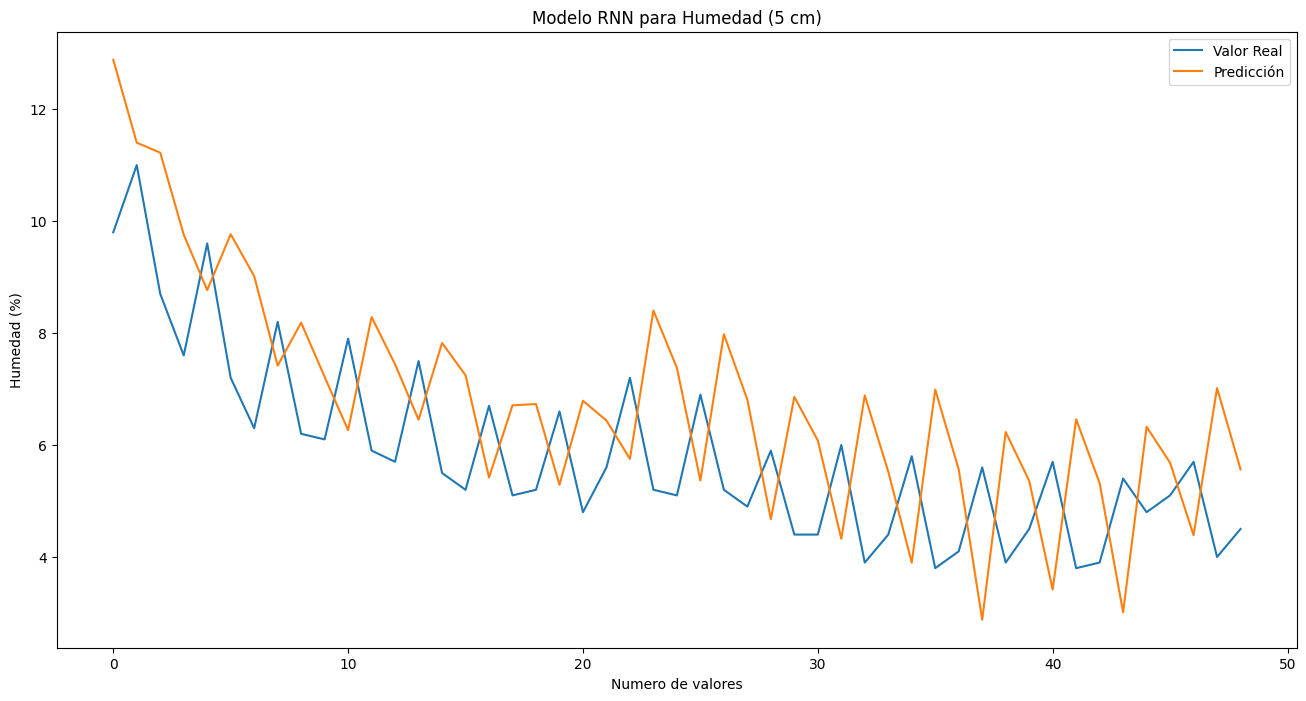

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Modelo RNN para Humedad (5 cm)')
plt.xlabel('Numero de valores')
plt.ylabel('Humedad (%)')
plt.plot(y_test_real, label="Valor Real")
plt.plot(predictions, label="Predicción")
plt.legend()
plt.show()


## Bloque 16: Predicción de Valores Futuros

En este bloque, extendemos la capacidad predictiva del modelo para generar una serie de valores futuros (en este caso, para los próximos 10 "días" o intervalos de 8 horas, según la frecuencia de los datos). Para ello, se toma la última secuencia conocida, se predice el siguiente valor, y ese valor se añade a la secuencia, que luego se desplaza para predecir el siguiente, en un proceso iterativo. Los valores resultantes son luego desescalados a su rango original.

In [ ]:
future_sequences = []
last_sequence = X[-1]  # última secuencia de entrenamiento
days = 10  # Número de días a predecir

for _ in range(days):
    next_value = model.predict(np.array([last_sequence]))[0, 0]
    last_sequence = np.concatenate((last_sequence[1:], [[next_value]]), axis=0)
    future_sequences.append(last_sequence)

future_sequences = np.array(future_sequences)
future_sequences = np.reshape(future_sequences, (future_sequences.shape[0], future_sequences.shape[1], 1))

future_predictions = model.predict(future_sequences)
future_predictions = scaler.inverse_transform(np.concatenate((future_predictions, np.zeros((future_predictions.shape[0], 0))), axis=1))[:,0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


## Bloque 17: Graficación de la Predicción a Futuro

Finalmente, este bloque visualiza la tendencia histórica de la humedad junto con la predicción de los próximos valores generados por el modelo. Esto proporciona una visión completa del comportamiento de la serie temporal y cómo el modelo estima que evolucionará la humedad en el futuro.

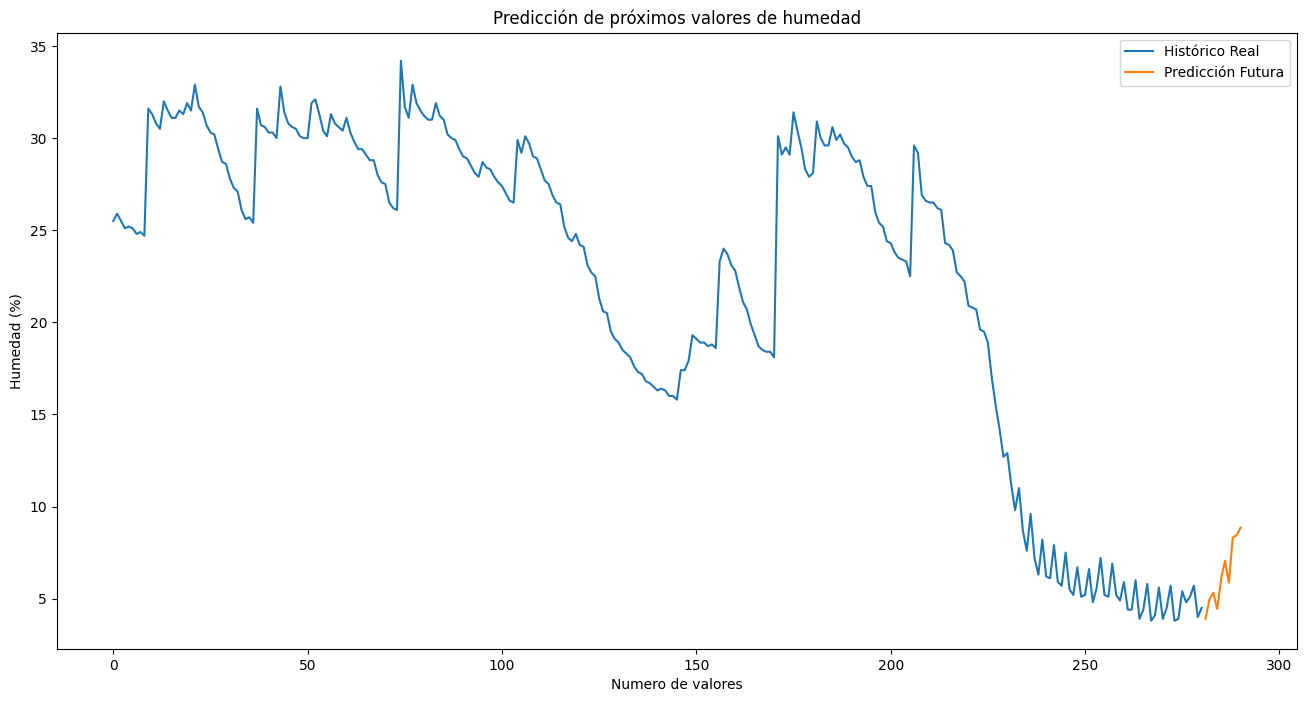

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Predicción de próximos valores de humedad')
plt.xlabel('Numero de valores')
plt.ylabel('Humedad (%)')
plt.plot(range(len(df_selected)), df_selected["Value"], label='Histórico Real')
plt.plot(range(len(df_selected), len(df_selected)+days), future_predictions, label='Predicción Futura')
plt.legend()
plt.show()